In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt


In [2]:
## This time we're going to use nn layers from torch instead of explicit hard-coded


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
## lets create the data.....
weight = 0.1
bias = 0.1

start, end, step = 0, 1, 0.02 
X = torch.arange(start, end , step).unsqueeze(dim = 1)
# print(X[:10])
y = weight*X + bias
# print(y[:10])

In [5]:
## split to create training and testing set
split_ratio = 0.7
train_split_mark = int(split_ratio*len(X))
# print(train_split_mark)
X_train, y_train = X[:train_split_mark], y[:train_split_mark]
X_test, y_test = X[train_split_mark:], y[train_split_mark:]
len(X_train),len(y_train),len(X_test),len(y_test)

(35, 35, 15, 15)

In [6]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

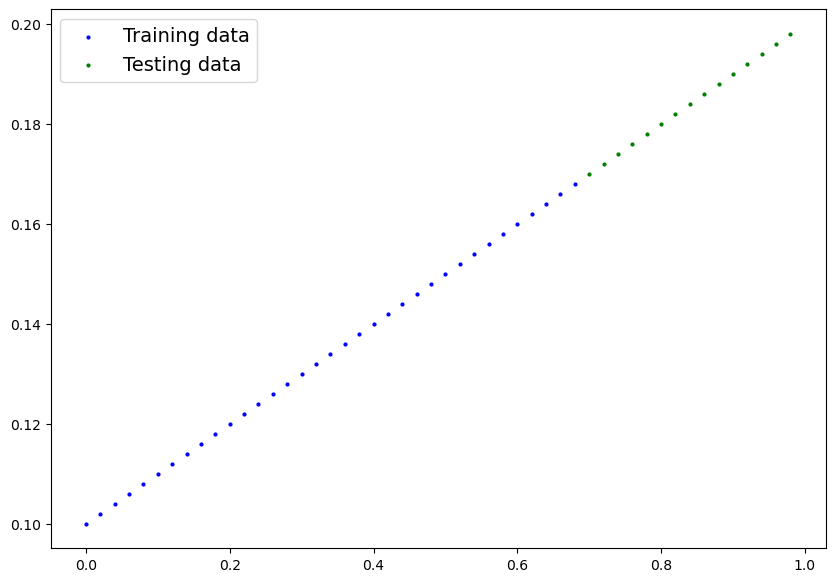

In [7]:
# Note: If you've reset your runtime, this function won't work, 
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

In [8]:
## Lets now build the pytorch Linear model
## using torch.nn subclasses


class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        ## using nn.Linear
        self.linear_layer = nn.Linear(in_features = 1, out_features=1)
        ## and thats all compared to our previos approach
        
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

    


In [9]:
torch.manual_seed(53)
model = LinearRegressionModel()
model, model.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.4912]])),
              ('linear_layer.bias', tensor([0.5226]))]))

In [10]:
## checking if the model is loaded onto GPU
next(model.parameters()).device

device(type='cpu')

In [11]:
## as expected it isn't, so lets load it to the GPU
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [12]:
## Now lets lay some ground work for the training

## create a loss function
loss_fn = nn.L1Loss()
## creating an optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr =0.04)


In [13]:
torch.manual_seed(53)
## start of the training loop

epochs = 1000

## This time we're going to put the entire data on the GPU
## make sure you've Enough VRAM for your GPU
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

## training loop

for epoch in range(epochs):
    ## specifying the mode[Training]
    model.train()
    
    ## forward pass
    y_pred = model(X_train)
    
    ## calc loss
    loss = loss_fn(y_pred, y_train)
    
    ## set Grad to 0
    optimizer.zero_grad()
    
    
    ## loss backward-.backprop
    loss.backward()
    
    ## update the optimizer
    optimizer.step()
    
    
    ## Testing out the model
    model.eval()
    
    ## forward pass
    with torch.inference_mode():
        ## forward pass
        test_pred = model(X_test)
        ## calc loss
        test_loss = loss_fn(test_pred, y_test)
        ## ok thats all
    
    if epoch%100==0:
        print(f"Epoch: {epoch}, train_loss: {loss}, test_loss: {test_loss}")
        
    




Epoch: 0, train_loss: 0.5555478930473328, test_loss: 0.6997004151344299
Epoch: 100, train_loss: 0.012970374897122383, test_loss: 0.05343583598732948
Epoch: 200, train_loss: 0.012970374897122383, test_loss: 0.05343583598732948
Epoch: 300, train_loss: 0.012970374897122383, test_loss: 0.05343583598732948
Epoch: 400, train_loss: 0.012970374897122383, test_loss: 0.05343583598732948
Epoch: 500, train_loss: 0.012970374897122383, test_loss: 0.05343583598732948
Epoch: 600, train_loss: 0.012970374897122383, test_loss: 0.05343583598732948
Epoch: 700, train_loss: 0.012970374897122383, test_loss: 0.05343583598732948
Epoch: 800, train_loss: 0.012970374897122383, test_loss: 0.05343583598732948
Epoch: 900, train_loss: 0.012970374897122383, test_loss: 0.05343583598732948


In [14]:
print(f"weights: {weight}, bias: {bias} and model's params: {model.state_dict()}")


weights: 0.1, bias: 0.1 and model's params: OrderedDict([('linear_layer.weight', tensor([[0.1300]], device='cuda:0')), ('linear_layer.bias', tensor([0.0768], device='cuda:0'))])


In [15]:
## lets make some predictions
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)
y_preds


tensor([[0.1678],
        [0.1704],
        [0.1730],
        [0.1756],
        [0.1782],
        [0.1808],
        [0.1834],
        [0.1860],
        [0.1886],
        [0.1912],
        [0.1938],
        [0.1964],
        [0.1990],
        [0.2016],
        [0.2042]], device='cuda:0')

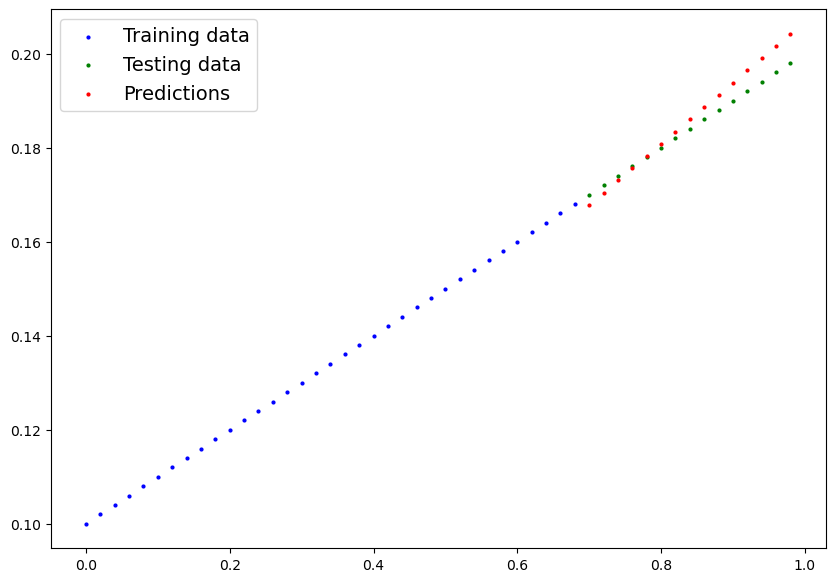

In [16]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

In [17]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_B.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_B.pth


In [18]:
## thats all folks for today....
